[article, ici](https://arxiv.org/pdf/2103.04318.pdf)

[github, ici](https://github.com/aimat-lab/gcnn_keras)



In [1]:
!git clone https://github.com/aimat-lab/gcnn_keras.git

Cloning into 'gcnn_keras'...
remote: Enumerating objects: 3248, done.
remote: Counting objects: 100% (323/323), done.
remote: Compressing objects: 100% (222/222), done.
remote: Total 3248 (delta 218), reused 194 (delta 101), pack-reused 2925
Receiving objects: 100% (3248/3248), 2.56 MiB | 9.98 MiB/s, done.
Resolving deltas: 100% (2216/2216), done.


In [2]:
%cd gcnn_keras/

/content/gcnn_keras


In [3]:
!ls

AUTHORS  examples  LICENSE	README.md	  setup.py
docs	 kgcnn	   MANIFEST.in	requirements.txt  test


In [49]:
del MUTAGDataset, make_unet, add_self_loops_to_edge_indices, ragged_tensor_from_nested_numpy, lr_lin_reduction, model

In [4]:
import time

# mpl.use('Agg')
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

from kgcnn.data.datasets.mutag import MUTAGDataset
from kgcnn.literature.Unet import make_unet as make_unet
from kgcnn.utils.adj import add_self_loops_to_edge_indices
from kgcnn.utils.data import ragged_tensor_from_nested_numpy
from kgcnn.utils.learning import lr_lin_reduction

INFO: Dataset directory located at /root/.kgcnn/datasets
INFO: Downloading dataset... done
INFO: Read zip file ... done
INFO: Extracting zip file...done
Datainfo: Mol index which has unconnected [] with [] in total 0
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
node_input (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
node_embedding (Embedding)      (None, None, 128)    7680        node_input[0][0]                 
__________________________________________________________________________________________________
edge_index_input (InputLayer)   [(None, None, 2)]    0                                            
__________________________________________________________________________________________________
change_tensor_type (ChangeTenso [(None, 128), (None, 0           node_embedding[0][0]             
______________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model/pooling_local_edges_1/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model/pooling_local_edges_1/Reshape:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/model/pooling_local_edges_1/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model/gather_nodes_outgoing_1/Reshape_1:0", shape=(None,), dtype=int64), values=Tensor("gradient_tape/model/gather_nodes_outgoing_1/Reshape:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/model/gather_n

6/6 - 5s - loss: 0.6863 - accuracy: 0.6686 - val_loss: 0.6838 - val_accuracy: 0.6316
Print Time for taining:  4.568526482000001


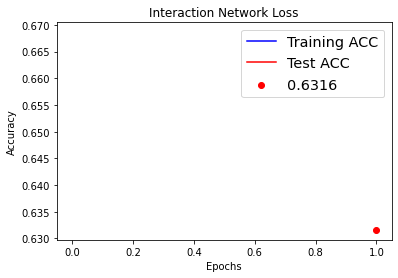

In [5]:
# Download and prepare dataset
dataset = MUTAGDataset()
labels, nodes, edge_indices, edges = dataset.get_graph()
labels[labels < 0] = 0
labels = np.expand_dims(labels, axis=-1)
graph_state = np.array([len(x) for x in nodes])
edge_indices = [add_self_loops_to_edge_indices(x) for x in edge_indices]
edges = [np.ones_like(x, dtype=np.float)[:, 0:1] for x in edge_indices]

# Train Test split
labels_train, labels_test, nodes_train, nodes_test, edges_train, edges_test, edge_indices_train, edge_indices_test, graph_state_train, graph_state_test = train_test_split(
    labels, nodes, edges, edge_indices, graph_state, test_size=0.10, random_state=42)
del labels, nodes, edges, edge_indices, graph_state  # Free memory after split, if possible

# Convert to tf.RaggedTensor or tf.tensor
# a copy of the data is generated by ragged_tensor_from_nested_numpy()
nodes_train, edges_train, edge_indices_train, graph_state_train = ragged_tensor_from_nested_numpy(
    nodes_train), ragged_tensor_from_nested_numpy(edges_train), ragged_tensor_from_nested_numpy(
    edge_indices_train), tf.constant(graph_state_train)

nodes_test, edges_test, edge_indices_test, graph_state_test = ragged_tensor_from_nested_numpy(
    nodes_test), ragged_tensor_from_nested_numpy(edges_test), ragged_tensor_from_nested_numpy(
    edge_indices_test), tf.constant(graph_state_test)

# Define input and output data
xtrain = nodes_train, edges_train, edge_indices_train
xtest = nodes_test, edges_test, edge_indices_test
ytrain = labels_train
ytest = labels_test

model = make_unet(
    input_node_shape=[None],
    input_edge_shape=[None, 1],
    input_embedd={"input_node_vocab": 60,
                  "input_node_embedd": 128},
    # Output
    output_embedd={"output_mode": 'graph', "output_type": 'padded'},
    output_mlp={"use_bias": [True, False], "units": [25, 1],
                "activation": ['relu', 'sigmoid'],
                },
    # Model specific
    hidden_dim=128,
    depth=1,
    k=0.3,
    score_initializer='ones',
    use_bias=True,
    activation='relu',
    is_sorted=False,
    has_unconnected=True,
    use_reconnect=True
)

# Define learning rate
learning_rate_start = 1e-4
learning_rate_stop = 1e-5
epo = 1
epomin = 400
epostep = 1

# Compile model with optimizer
optimizer = tf.keras.optimizers.Adam(lr=learning_rate_start)
cbks = tf.keras.callbacks.LearningRateScheduler(lr_lin_reduction(learning_rate_start, learning_rate_stop, epomin, epo))
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
print(model.summary())

start = time.process_time()
hist = model.fit(xtrain, ytrain,
                 epochs=epo,
                 batch_size=32,
                 callbacks=[cbks],
                 validation_freq=epostep,
                 validation_data=(xtest, ytest),
                 verbose=2
                 )
stop = time.process_time()
print("Print Time for taining: ", stop - start)

trainlossall = np.array(hist.history['accuracy'])
testlossall = np.array(hist.history['val_accuracy'])

mae_valid = testlossall[-1]

# Plot loss vs epochs
plt.figure()
plt.plot(np.arange(trainlossall.shape[0]), trainlossall, label='Training ACC', c='blue')
plt.plot(np.arange(epostep, epo + epostep, epostep), testlossall, label='Test ACC', c='red')
plt.scatter([trainlossall.shape[0]], [mae_valid], label="{0:0.4f} ".format(mae_valid), c='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Interaction Network Loss')
plt.legend(loc='upper right', fontsize='x-large')
plt.savefig('unet_loss.png')
plt.show()

In [6]:
model.save("test.h5")

ListWrapper(['units', 'activation', 'use_bias', 'kernel_initializer', 'bias_initializer', 'kernel_regularizer', 'bias_regularizer', 'activity_regularizer', 'kernel_constraint', 'bias_constraint'])
ListWrapper(['units', 'activation', 'use_bias', 'kernel_initializer', 'bias_initializer', 'kernel_regularizer', 'bias_regularizer', 'activity_regularizer', 'kernel_constraint', 'bias_constraint'])
ListWrapper(['activation', 'activity_regularizer'])
ListWrapper([])
ListWrapper(['units', 'activation', 'use_bias', 'kernel_initializer', 'bias_initializer', 'kernel_regularizer', 'bias_regularizer', 'activity_regularizer', 'kernel_constraint', 'bias_constraint'])
ListWrapper(['activation', 'activity_regularizer'])


In [10]:
from kgcnn.layers.casting import ChangeTensorType, ChangeIndexing
from kgcnn.layers.connect import AdjacencyPower
from kgcnn.layers.gather import GatherNodesOutgoing
from kgcnn.layers.keras import Dense, Activation, Add
from kgcnn.layers.mlp import MLP
from kgcnn.layers.pooling import PoolingNodes, PoolingLocalEdges
from kgcnn.layers.topk import PoolingTopK, UnPoolingTopK
from kgcnn.ops.models import generate_standard_graph_input, update_model_args

In [11]:
custom_objects = {'ChangeTensorType':ChangeTensorType}
model_saved = tf.keras.models.load_model("test.h5", custom_objects=custom_objects)

TypeError: ignored